# Trivial music genre classification
Inspired by the first lecture of the FastAI's 'Practial Deep Learning for Coders' online course, I've coded and trained this trivial music genre classification model in less than an hour.<br>
P.S. I wouldn't think that such a simple model is so fun to code and train, but honestly, before the lecture, I geniunely had no idea that this is actually how most audio classification models work: first creating a VISUAL representation of the soundwaves, and then working with the data in the form of an image.

Let's write a function to generate the spectogram of an MP3 file. For computational reasons, let's only work with the spectograms of 5 equally distributed 5-seconds-long periods.

In [9]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def create_spectograms(file_path):
    y, sr = librosa.load(file_path, sr=None)  # y is the audio time series, sr is the sampling rate

    # Define the duration of each segment in seconds
    segment_duration = 5  # 5 seconds
    segment_samples = segment_duration * sr  # Convert duration to samples

    segments = []
    for start in range(0, len(y), segment_samples):
        end = min(start + segment_samples, len(y))
        segments.append(y[start:end])
        
    num_segments = len(segments)
    plots = []
    for segment_num, percent in enumerate([0, 25, 50, 75, 100]): # We'll take 5 equally distributed 5-seconds-long spectrograms
        index = int((num_segments-1)/100*percent)
        segment = segments[index]
        
        D = np.abs(librosa.stft(segment))
        D_log = librosa.amplitude_to_db(D, ref=np.max)

        plt.figure(figsize=(12, 6))
        librosa.display.specshow(D_log, sr=sr, x_axis=None, y_axis=None, cmap='coolwarm')  # No axes
        plt.axis('off')
        plots.append(plt.gcf())
    return plots


The dataset that I used consisted of 300 songs, a hundred for each of the music genres: rock, classical, hiphop. Here I Iterate though them, creating 5 spectograms for each.

In [11]:
import os
import gc

base_data_dir = '/home/herb/Music/fastai/'
base_ds_dir = '/home/herb/Documents/programming/genre-classification/dataset/'
total = 0

for genre in ('rock', 'classical', 'hiphop'):
    ds_dir = os.path.join(base_ds_dir, genre)
    data_dir = os.path.join(base_data_dir, genre)
    os.makedirs(ds_dir, exist_ok=True)

    for file_ind, file in enumerate(os.listdir(data_dir)):
        plots = create_spectograms(os.path.join(data_dir, file))
        for plot_ind, plot in enumerate(plots):
            plot.savefig(os.path.join(ds_dir, f'spectrogram_{file_ind+1}_{plot_ind+1}.png'), bbox_inches='tight', pad_inches=0, dpi=300)
            total += 1
            print(f'Saved spectogram #{total}')
            plt.close(plot)
        gc.collect()


Saved spectogram #1
Saved spectogram #2
Saved spectogram #3
Saved spectogram #4
Saved spectogram #5


FastAI's magic begins here.

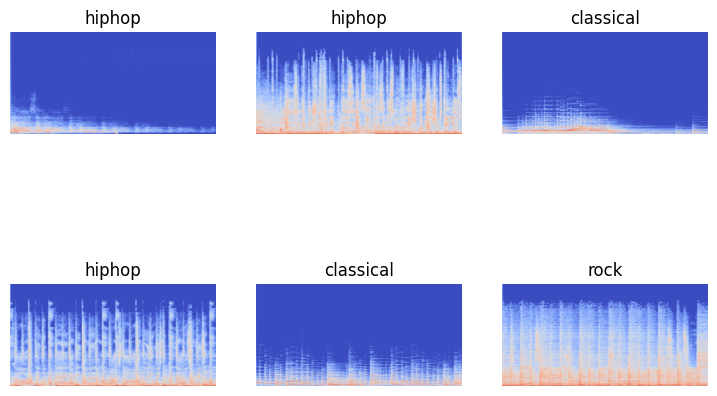

In [3]:
from fastai.vision.all import *
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize((308, 620), method='squish')]
).dataloaders('dataset', bs=32)

dls.show_batch(max_n=6)

Below is all the training code that you need for this kind of task.

In [4]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/herb/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth

00%|███████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:38<00:00, 1.21MB/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.125848,0.776341,0.232704,04:44


epoch,train_loss,valid_loss,error_rate,time
0,0.576267,0.612978,0.191824,06:28
1,0.439486,0.636299,0.188679,06:57
2,0.318448,0.559948,0.157233,07:20
3,0.200489,0.578893,0.176101,06:51
4,0.128473,0.550880,0.166667,04:54


Finally, let's create the inference function and save the model.

In [21]:
predict_dir = '/home/herb/Documents/programming/genre-classification/predict/'
os.makedirs(predict_dir, exist_ok=True)
os.chdir(predict_dir)

def predict(file_path):
    plots = create_spectograms(file_path)
    for ind, plot in enumerate(plots):
        plot.savefig(f'spectrogram_{ind+1}.png', bbox_inches='tight', pad_inches=0, dpi=300)
        plt.close(plot)
    predicted = [learn.predict(PILImage.create(f'spectrogram_{i+1}.png'))[0] for i in range(5)]
    genre = max(predicted, key=lambda x: predicted.count(x))
    print(f"This is: {genre}.")

predict('test.mp3')


This is: rock.


In [25]:
learn.save('genre-classificator')

Path('models/genre-classificator.pth')